In [35]:
!pip install zip-files

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [28]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#

In [31]:

#!kaggle kernels pull tanmay111999/fraud-detection-smote-f1-score-90-5-models

In [52]:
data=pd.read_csv('/content/creditcard.csv')

In [53]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194194 entries, 0 to 194193
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    194194 non-null  float64
 1   V1      194194 non-null  float64
 2   V2      194194 non-null  float64
 3   V3      194194 non-null  float64
 4   V4      194194 non-null  float64
 5   V5      194194 non-null  float64
 6   V6      194194 non-null  float64
 7   V7      194194 non-null  float64
 8   V8      194194 non-null  float64
 9   V9      194194 non-null  float64
 10  V10     194194 non-null  float64
 11  V11     194194 non-null  float64
 12  V12     194194 non-null  float64
 13  V13     194194 non-null  float64
 14  V14     194194 non-null  float64
 15  V15     194194 non-null  float64
 16  V16     194194 non-null  float64
 17  V17     194194 non-null  float64
 18  V18     194194 non-null  float64
 19  V19     194194 non-null  float64
 20  V20     194194 non-null  float64
 21  V21     19

In [63]:
data.isnull().values.any()


True

In [56]:
data['Class'].value_counts()

,count
Class,
0.0,193812
1.0,381


In [64]:
fraud=data[data['Class']==1]
normal=data[data['Class']==0]

In [66]:
print(fraud.shape,normal.shape)

(381, 32) (193812, 32)


In [68]:
fraud.Amount.describe()

,Amount
count,381.000000
mean,116.421155
std,247.034583
min,0.000000
25%,1.000000
50%,11.400000
75%,104.030000
max,2125.870000


In [70]:
normal.Amount.describe()

,Amount
count,193812.000000
mean,89.425440
std,248.512542
min,0.000000
25%,5.990000
50%,22.900000
75%,79.000000
max,19656.530000


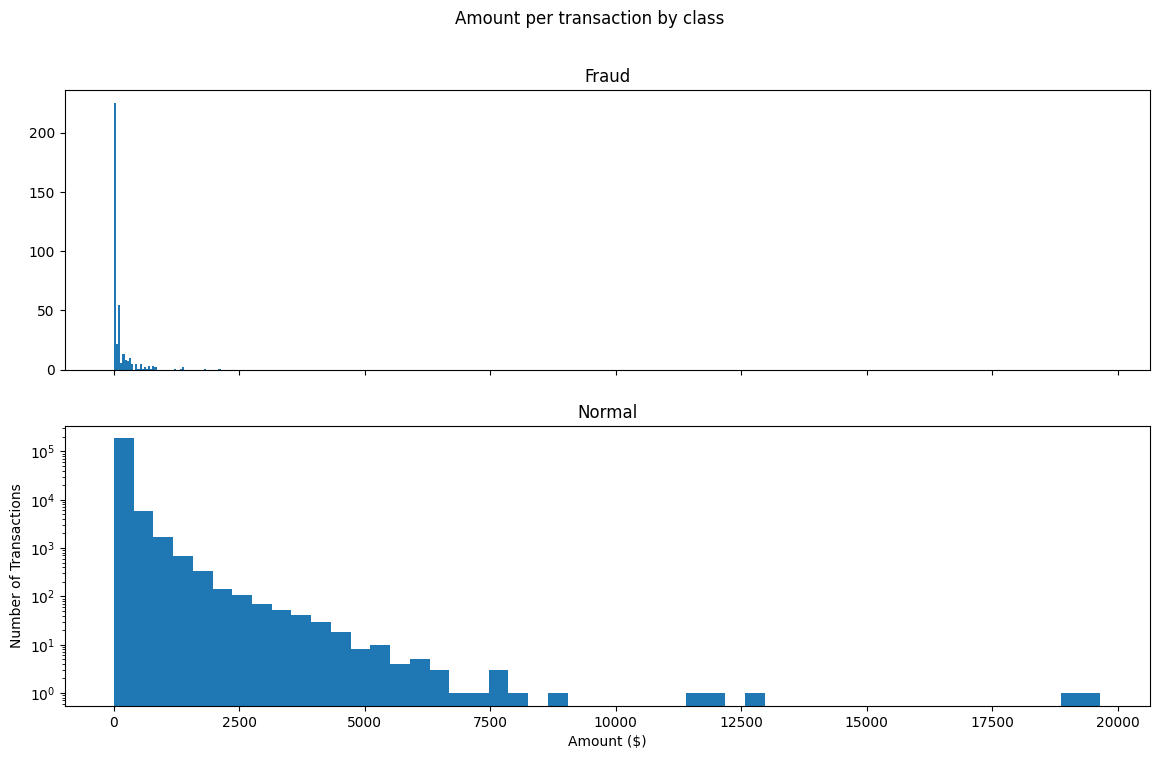

In [74]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
bins=50
ax1.hist(fraud.Amount,bins=bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount,bins=bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

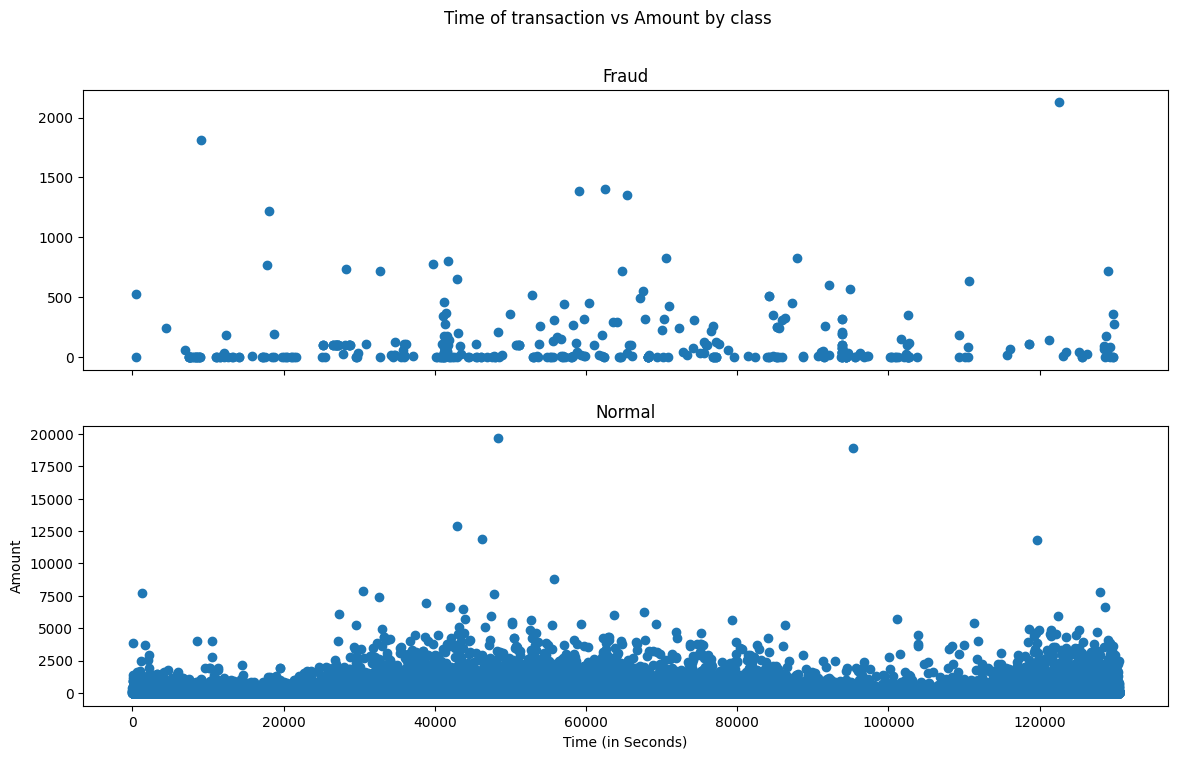

In [76]:
f,(ax1,ax2)=plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time,fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time,normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show();

In [77]:
#table sameple of the data
data1=data.sample(frac=0.1,random_state=1)
data1.shape

(19419, 32)

In [78]:
fraud=data1[data1['Class']==1]
normal=data1[data1['Class']==0]
outlier_fraction=len(fraud)/float(len(normal))

In [80]:
print(outlier_fraction)
print('Fraud Cases: {}'.format(len(fraud)))
print('Normal Cases: {}'.format(len(normal)))

0.0020123839009287925
Fraud Cases: 39
Normal Cases: 19380


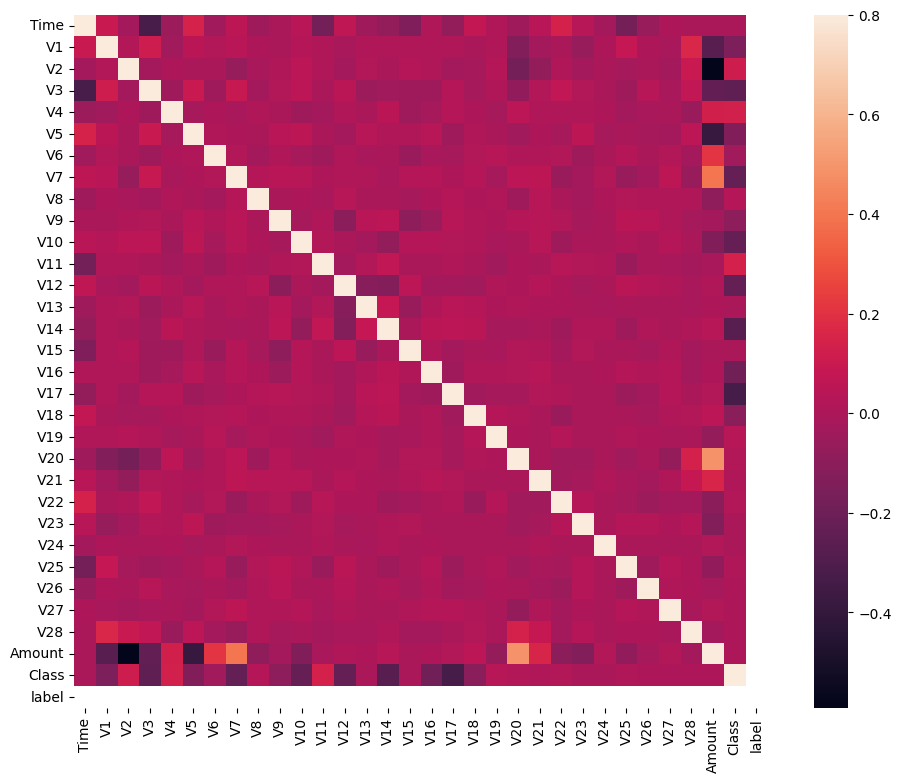

In [81]:
cormat=data1.corr()
fig=plt.figure(figsize=(12,9))
sns.heatmap(cormat,vmax=0.8,square=True)
plt.show()

In [82]:
coloumn=data1.columns.tolist()
coloumn=[c for c in coloumn if c not in ['Class']]
target='Class'
state=np.random.RandomState(42)
x=data1[coloumn]
y=data1[target]
print(x.shape)
print(y.shape)

(19419, 31)
(19419,)


In [84]:
classifiers={
    "Isolation Forest":IsolationForest(n_estimators=100,max_samples=len(x),contamination=outlier_fraction,random_state=state,verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20,algorithm='auto',leaf_size=30,metric='minkowski',metric_params=None,contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf',degree=3,gamma=0.1,nu=0.05,max_iter=-1) # Removed random_state
}

In [85]:
type(classifiers)

dict

In [86]:
n_outliers=len(fraud)
for i,(clf_name,clf) in enumerate(classifiers.items()):
  if clf_name=="Support Vector Machine":
    clf.fit(x)
    y_pred=clf.predict(x)
  elif clf_name=="Local Outlier Factor":
    y_pred=clf.fit_predict(x)
  else:
    clf.fit(x)
    scores_pred=clf.decision_function(x)
    y_pred=clf.predict(x)
  y_pred[y_pred==1]=0
  y_pred[y_pred==-1]=1
  n_errors=(y_pred!=y).sum()
  print('{}: {}'.format(clf_name,n_errors))
  print(accuracy_score(y,y_pred))
  print(classification_report(y,y_pred))

Isolation Forest: 51
0.9973737061640662
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19380
         1.0       0.35      0.36      0.35        39

    accuracy                           1.00     19419
   macro avg       0.67      0.68      0.68     19419
weighted avg       1.00      1.00      1.00     19419

Local Outlier Factor: 79
0.9959318193521809
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19380
         1.0       0.00      0.00      0.00        39

    accuracy                           1.00     19419
   macro avg       0.50      0.50      0.50     19419
weighted avg       1.00      1.00      1.00     19419

Support Vector Machine: 5732
0.704825171224059
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     19380
         1.0       0.00      0.18      0.00        39

    accuracy                           0.70     194